In [1]:
'''
!pip install Cython
!git clone https://github.com/waleedka/coco.git

!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI
'''

'\n!pip install Cython\n!git clone https://github.com/waleedka/coco.git\n\n!pip install -U setuptools\n!pip install -U wheel\n!make install -C coco/PythonAPI\n'

In [2]:
import os
import sys
import random
import math
import numpy as np
import csv
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import imageio
import datetime
import tensorflow as tf
import keras
from keras.callbacks import LearningRateScheduler



# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Ignore Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
print(ROOT_DIR)
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/interior/"))  # To find local version
sys.path.append('')  # To find local version
import projection1
import interior_seq

%matplotlib inline 
%load_ext tensorboard

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
print('finished')

/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dty

/media/scratch1/erbachj/Mask_RCNN
The tensorboard module is not an IPython extension.
finished


In [3]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


In [4]:
class_names = ['BG', 'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa',
               'table', 'door', 'window', 'bookshelf', 'picture', 'counter',
               'blinds', 'desk', 'shelves', 'curtain', 'dresser', 'pillow', 
               'mirror', 'floor', 'clothes', 'ceiling', 'books', 'refridgerator',
               'television', 'paper', 'towel', 'shower', 'box', 'whiteboard', 
               'person', 'night', 'toilet', 'sink', 'lamp', 'bathtub', 'bag', 
               'otherstructure', 'otherfurniture', 'otherprop']

selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'window', 
                    'picture', 'blinds', 'shelves', 'curtain', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
# without curtain
selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'window', 
                    'picture', 'blinds', 'shelves', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
print(class_names[15])

shelves


In [5]:
NYU40_to_sel_map = {}
selected_class_list = []

for i in range(len(class_names)):
    if class_names[i] in selected_classes:
        NYU40_to_sel_map[i] = selected_classes.index(class_names[i])
        selected_class_list.append(i)
    else:
        NYU40_to_sel_map[i] = 0
NYU40_to_sel_map[class_names.index('desk')] = selected_classes.index('table')
NYU40_to_sel_map[class_names.index('bookshelf')] = selected_classes.index('shelves')
NYU40_to_sel_map[class_names.index('refridgerator')] = selected_classes.index('refrigerator')
selected_class_list.append(class_names.index('desk'))
selected_class_list.append(class_names.index('bookshelf'))
selected_class_list.append(class_names.index('refridgerator'))

"""
NYU40_to_sel_map = {'BG': 'BG', 'wall': 'BG', 'floor': 'BG', 'cabinet': 'cabinet', 
                    'bed': 'bed', 'chair': 'chair', 'sofa': 'sofa', 'table': 'table', 
                    'door': 'BG', 'window': 'window', 'bookshelf': 'shelves', 
                    'picture': 'picture', 'counter': 'BG', 'blinds': 'blinds', 
                    'desk': 'table', 'shelves': 'shelves', 'curtain': 'curtain', 
                    'dresser': 'dresser', 'pillow': 'pillow', 'mirror': 'mirror', 
                    'clothes': 'clothes', 'ceiling': 'BG', 'books': 'books', 
                    'refridgerator': 'refrigerator', 'television': 'television', 
                    'paper': 'paper', 'towel': 'towel', 'shower': 'BG', 'box': 'BG', 
                    'whiteboard': 'BG', 'person': 'BG', 'night': 'BG', 'toilet': 'toilet',
                    'sink': 'sink', 'lamp': 'lamp', 'bathtub': 'bathtub', 'bag': 'bag', 
                    'otherstructure': 'BG', 'otherfurniture': 'BG', 'otherprop': 'BG'}
"""

print(NYU40_to_sel_map)
print(selected_class_list)

{0: 0, 1: 0, 2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 0, 9: 6, 10: 9, 11: 7, 12: 0, 13: 8, 14: 5, 15: 9, 16: 0, 17: 10, 18: 11, 19: 12, 20: 0, 21: 13, 22: 0, 23: 14, 24: 15, 25: 16, 26: 17, 27: 18, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 19, 34: 20, 35: 21, 36: 22, 37: 23, 38: 0, 39: 0, 40: 0}
[0, 3, 4, 5, 6, 7, 9, 11, 13, 15, 17, 18, 19, 21, 23, 25, 26, 27, 33, 34, 35, 36, 37, 14, 10, 24]


In [6]:
#TRAIN_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDDWIQX7_Dining_room'
#TRAIN_DIR = os.path.join(TRAIN_DIR,'cam0/data/')
TRAIN_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')
print(TRAIN_DIR)
# Training dataset
dataset_train = interior_seq.InteriorDataset()
dataset_train.load_Interior(dataset_dir=TRAIN_DIR, subset='train', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_train.prepare()

# Validation dataset
#VAL_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDEI1LAV_Dining_room'
#VAL_DIR = os.path.join(VAL_DIR,'cam0/data/')
VAL_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')

dataset_val = interior_seq.InteriorDataset()
dataset_val.load_Interior(dataset_dir=VAL_DIR, subset='val', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_val.prepare()

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7
HD7
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMIGOGN1_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMIGOGN1_Bedroom_id0
3FO4MMIGOGN1_Bedroom_id1
3FO4MMIGOGN1_Bedroom_id2
3FO4MMIGOGN1_Bedroom_id3
3FO4MMIGOGN1_Bedroom_id4
3FO4MMIGOGN1_Bedroom_id5
3FO4MMIGOGN1_Bedroom_id6
3FO4MMIGOGN1_Bedroom_id7
3FO4MMIGOGN1_Bedroom_id8
3FO4MMIGOGN1_Bedroom_id9
3FO4MMIGOGN1_Bedroom_id10
3FO4MMIGOGN1_Bedroom_id11
3FO4MMIGOGN1_Bedroom_id12
3FO4MMIGOGN1_Bedroom_id13
3FO4MMIGOGN1_Bedroom_id14
3FO4MMIGOGN1_Bedroom_id15
3FO4MMIGOGN1_Bedroom_id16
3FO4MMIGOGN1_Bedroom_id17
3FO4MMIGOGN1_Bedroom_id18
3FO4MMIGOGN1_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKV6CI92_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKV6CI92_Living_room_id0
3FO4MKV6CI92_Living_room_id1
3FO4MKV6CI92_Living_room

3FO4MA9H2E5X_Dining_room_id8
3FO4MA9H2E5X_Dining_room_id9
3FO4MA9H2E5X_Dining_room_id10
3FO4MA9H2E5X_Dining_room_id11
3FO4MA9H2E5X_Dining_room_id12
3FO4MA9H2E5X_Dining_room_id13
3FO4MA9H2E5X_Dining_room_id14
3FO4MA9H2E5X_Dining_room_id15
3FO4MA9H2E5X_Dining_room_id16
3FO4MA9H2E5X_Dining_room_id17
3FO4MA9H2E5X_Dining_room_id18
3FO4MA9H2E5X_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFPNTOAC_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFPNTOAC_Living_room_id0
3FO4MFPNTOAC_Living_room_id1
3FO4MFPNTOAC_Living_room_id2
3FO4MFPNTOAC_Living_room_id3
3FO4MFPNTOAC_Living_room_id4
3FO4MFPNTOAC_Living_room_id5
3FO4MFPNTOAC_Living_room_id6
3FO4MFPNTOAC_Living_room_id7
3FO4MFPNTOAC_Living_room_id8
3FO4MFPNTOAC_Living_room_id9
3FO4MFPNTOAC_Living_room_id10
3FO4MFPNTOAC_Living_room_id11
3FO4MFPNTOAC_Living_room_id12
3FO4MFPNTOAC_Living_room_id13
3FO4MFPNTOAC_Living_room_id14
3FO4MFPNTOAC_Living_room_id1

3FO4MLNLYKOH_Living_room_id16
3FO4MLNLYKOH_Living_room_id17
3FO4MLNLYKOH_Living_room_id18
3FO4MLNLYKOH_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGOV1CUY_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGOV1CUY_Living_room_id0
3FO4MGOV1CUY_Living_room_id1
3FO4MGOV1CUY_Living_room_id2
3FO4MGOV1CUY_Living_room_id3
3FO4MGOV1CUY_Living_room_id4
3FO4MGOV1CUY_Living_room_id5
3FO4MGOV1CUY_Living_room_id6
3FO4MGOV1CUY_Living_room_id7
3FO4MGOV1CUY_Living_room_id8
3FO4MGOV1CUY_Living_room_id9
3FO4MGOV1CUY_Living_room_id10
3FO4MGOV1CUY_Living_room_id11
3FO4MGOV1CUY_Living_room_id12
3FO4MGOV1CUY_Living_room_id13
3FO4MGOV1CUY_Living_room_id14
3FO4MGOV1CUY_Living_room_id15
3FO4MGOV1CUY_Living_room_id16
3FO4MGOV1CUY_Living_room_id17
3FO4MGOV1CUY_Living_room_id18
3FO4MGOV1CUY_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM1TFFW8_Living_room
loading annotations into 

3FO4MJ4C0WJU_Living_room_id15
3FO4MJ4C0WJU_Living_room_id16
3FO4MJ4C0WJU_Living_room_id17
3FO4MJ4C0WJU_Living_room_id18
3FO4MJ4C0WJU_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MJXW9OCD_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MJXW9OCD_Living_room_id0
3FO4MJXW9OCD_Living_room_id1
3FO4MJXW9OCD_Living_room_id2
3FO4MJXW9OCD_Living_room_id3
3FO4MJXW9OCD_Living_room_id4
3FO4MJXW9OCD_Living_room_id5
3FO4MJXW9OCD_Living_room_id6
3FO4MJXW9OCD_Living_room_id7
3FO4MJXW9OCD_Living_room_id8
3FO4MJXW9OCD_Living_room_id9
3FO4MJXW9OCD_Living_room_id10
3FO4MJXW9OCD_Living_room_id11
3FO4MJXW9OCD_Living_room_id12
3FO4MJXW9OCD_Living_room_id13
3FO4MJXW9OCD_Living_room_id14
3FO4MJXW9OCD_Living_room_id15
3FO4MJXW9OCD_Living_room_id16
3FO4MJXW9OCD_Living_room_id17
3FO4MJXW9OCD_Living_room_id18
3FO4MJXW9OCD_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLXTBTF2_Bedroom

3FO4MGLY0I21_Living_room_id11
3FO4MGLY0I21_Living_room_id12
3FO4MGLY0I21_Living_room_id13
3FO4MGLY0I21_Living_room_id14
3FO4MGLY0I21_Living_room_id15
3FO4MGLY0I21_Living_room_id16
3FO4MGLY0I21_Living_room_id17
3FO4MGLY0I21_Living_room_id18
3FO4MGLY0I21_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MEYK5BB7_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MEYK5BB7_Living_room_id0
3FO4MEYK5BB7_Living_room_id1
3FO4MEYK5BB7_Living_room_id2
3FO4MEYK5BB7_Living_room_id3
3FO4MEYK5BB7_Living_room_id4
3FO4MEYK5BB7_Living_room_id5
3FO4MEYK5BB7_Living_room_id6
3FO4MEYK5BB7_Living_room_id7
3FO4MEYK5BB7_Living_room_id8
3FO4MEYK5BB7_Living_room_id9
3FO4MEYK5BB7_Living_room_id10
3FO4MEYK5BB7_Living_room_id11
3FO4MEYK5BB7_Living_room_id12
3FO4MEYK5BB7_Living_room_id13
3FO4MEYK5BB7_Living_room_id14
3FO4MEYK5BB7_Living_room_id15
3FO4MEYK5BB7_Living_room_id16
3FO4MEYK5BB7_Living_room_id17
3FO4MEYK5BB7_Living_room_i

3FO4MEV76WSI_Living_room_id7
3FO4MEV76WSI_Living_room_id8
3FO4MEV76WSI_Living_room_id9
3FO4MEV76WSI_Living_room_id10
3FO4MEV76WSI_Living_room_id11
3FO4MEV76WSI_Living_room_id12
3FO4MEV76WSI_Living_room_id13
3FO4MEV76WSI_Living_room_id14
3FO4MEV76WSI_Living_room_id15
3FO4MEV76WSI_Living_room_id16
3FO4MEV76WSI_Living_room_id17
3FO4MEV76WSI_Living_room_id18
3FO4MEV76WSI_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MDKK3TAX_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MDKK3TAX_Dining_room_id0
3FO4MDKK3TAX_Dining_room_id1
3FO4MDKK3TAX_Dining_room_id2
3FO4MDKK3TAX_Dining_room_id3
3FO4MDKK3TAX_Dining_room_id4
3FO4MDKK3TAX_Dining_room_id5
3FO4MDKK3TAX_Dining_room_id6
3FO4MDKK3TAX_Dining_room_id7
3FO4MDKK3TAX_Dining_room_id8
3FO4MDKK3TAX_Dining_room_id9
3FO4MDKK3TAX_Dining_room_id10
3FO4MDKK3TAX_Dining_room_id11
3FO4MDKK3TAX_Dining_room_id12
3FO4MDKK3TAX_Dining_room_id13
3FO4MDKK3TAX_Dining_room_id14

3FO4MAMINIVG_Dining_room_id10
3FO4MAMINIVG_Dining_room_id11
3FO4MAMINIVG_Dining_room_id12
3FO4MAMINIVG_Dining_room_id13
3FO4MAMINIVG_Dining_room_id14
3FO4MAMINIVG_Dining_room_id15
3FO4MAMINIVG_Dining_room_id16
3FO4MAMINIVG_Dining_room_id17
3FO4MAMINIVG_Dining_room_id18
3FO4MAMINIVG_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLXSPC3M_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLXSPC3M_Bedroom_id0
3FO4MLXSPC3M_Bedroom_id1
3FO4MLXSPC3M_Bedroom_id2
3FO4MLXSPC3M_Bedroom_id3
3FO4MLXSPC3M_Bedroom_id4
3FO4MLXSPC3M_Bedroom_id5
3FO4MLXSPC3M_Bedroom_id6
3FO4MLXSPC3M_Bedroom_id7
3FO4MLXSPC3M_Bedroom_id8
3FO4MLXSPC3M_Bedroom_id9
3FO4MLXSPC3M_Bedroom_id10
3FO4MLXSPC3M_Bedroom_id11
3FO4MLXSPC3M_Bedroom_id12
3FO4MLXSPC3M_Bedroom_id13
3FO4MLXSPC3M_Bedroom_id14
3FO4MLXSPC3M_Bedroom_id15
3FO4MLXSPC3M_Bedroom_id16
3FO4MLXSPC3M_Bedroom_id17
3FO4MLXSPC3M_Bedroom_id18
3FO4MLXSPC3M_Bedroom_id19
/media/scratch1/erba

3FO4MM1VT8BA_Bedroom_id12
3FO4MM1VT8BA_Bedroom_id13
3FO4MM1VT8BA_Bedroom_id14
3FO4MM1VT8BA_Bedroom_id15
3FO4MM1VT8BA_Bedroom_id16
3FO4MM1VT8BA_Bedroom_id17
3FO4MM1VT8BA_Bedroom_id18
3FO4MM1VT8BA_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLXTILT3_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLXTILT3_Bedroom_id0
3FO4MLXTILT3_Bedroom_id1
3FO4MLXTILT3_Bedroom_id2
3FO4MLXTILT3_Bedroom_id3
3FO4MLXTILT3_Bedroom_id4
3FO4MLXTILT3_Bedroom_id5
3FO4MLXTILT3_Bedroom_id6
3FO4MLXTILT3_Bedroom_id7
3FO4MLXTILT3_Bedroom_id8
3FO4MLXTILT3_Bedroom_id9
3FO4MLXTILT3_Bedroom_id10
3FO4MLXTILT3_Bedroom_id11
3FO4MLXTILT3_Bedroom_id12
3FO4MLXTILT3_Bedroom_id13
3FO4MLXTILT3_Bedroom_id14
3FO4MLXTILT3_Bedroom_id15
3FO4MLXTILT3_Bedroom_id16
3FO4MLXTILT3_Bedroom_id17
3FO4MLXTILT3_Bedroom_id18
3FO4MLXTILT3_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIC50Q4P_Living_room
loading annotations i

3FO4M9U3NSUP_Dining_room_id12
3FO4M9U3NSUP_Dining_room_id15
3FO4M9U3NSUP_Dining_room_id16
3FO4M9U3NSUP_Dining_room_id17
3FO4M9U3NSUP_Dining_room_id18
3FO4M9U3NSUP_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MEHW3RL6_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MEHW3RL6_Living_room_id0
3FO4MEHW3RL6_Living_room_id1
3FO4MEHW3RL6_Living_room_id2
3FO4MEHW3RL6_Living_room_id3
3FO4MEHW3RL6_Living_room_id4
3FO4MEHW3RL6_Living_room_id5
3FO4MEHW3RL6_Living_room_id6
3FO4MEHW3RL6_Living_room_id7
3FO4MEHW3RL6_Living_room_id8
3FO4MEHW3RL6_Living_room_id9
3FO4MEHW3RL6_Living_room_id10
3FO4MEHW3RL6_Living_room_id11
3FO4MEHW3RL6_Living_room_id12
3FO4MEHW3RL6_Living_room_id13
3FO4MEHW3RL6_Living_room_id14
3FO4MEHW3RL6_Living_room_id15
3FO4MEHW3RL6_Living_room_id16
3FO4MEHW3RL6_Living_room_id17
3FO4MEHW3RL6_Living_room_id18
3FO4MEHW3RL6_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/

3FO4MKG1XL3K_Living_room_id10
3FO4MKG1XL3K_Living_room_id11
3FO4MKG1XL3K_Living_room_id12
3FO4MKG1XL3K_Living_room_id13
3FO4MKG1XL3K_Living_room_id14
3FO4MKG1XL3K_Living_room_id15
3FO4MKG1XL3K_Living_room_id16
3FO4MKG1XL3K_Living_room_id17
3FO4MKG1XL3K_Living_room_id18
3FO4MKG1XL3K_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MF1C3MNO_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MF1C3MNO_Living_room_id0
3FO4MF1C3MNO_Living_room_id1
3FO4MF1C3MNO_Living_room_id3
3FO4MF1C3MNO_Living_room_id4
3FO4MF1C3MNO_Living_room_id5
3FO4MF1C3MNO_Living_room_id6
3FO4MF1C3MNO_Living_room_id7
3FO4MF1C3MNO_Living_room_id8
3FO4MF1C3MNO_Living_room_id9
3FO4MF1C3MNO_Living_room_id10
3FO4MF1C3MNO_Living_room_id11
3FO4MF1C3MNO_Living_room_id12
3FO4MF1C3MNO_Living_room_id13
3FO4MF1C3MNO_Living_room_id14
3FO4MF1C3MNO_Living_room_id15
3FO4MF1C3MNO_Living_room_id16
3FO4MF1C3MNO_Living_room_id17
3FO4MF1C3MNO_Living_room_

3FO4MEX3VNTR_Living_room_id1
3FO4MEX3VNTR_Living_room_id2
3FO4MEX3VNTR_Living_room_id3
3FO4MEX3VNTR_Living_room_id4
3FO4MEX3VNTR_Living_room_id5
3FO4MEX3VNTR_Living_room_id6
3FO4MEX3VNTR_Living_room_id7
3FO4MEX3VNTR_Living_room_id8
3FO4MEX3VNTR_Living_room_id12
3FO4MEX3VNTR_Living_room_id13
3FO4MEX3VNTR_Living_room_id14
3FO4MEX3VNTR_Living_room_id17
3FO4MEX3VNTR_Living_room_id18
3FO4MEX3VNTR_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMDBVKJ0_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMDBVKJ0_Bedroom_id0
3FO4MMDBVKJ0_Bedroom_id1
3FO4MMDBVKJ0_Bedroom_id2
3FO4MMDBVKJ0_Bedroom_id3
3FO4MMDBVKJ0_Bedroom_id4
3FO4MMDBVKJ0_Bedroom_id5
3FO4MMDBVKJ0_Bedroom_id6
3FO4MMDBVKJ0_Bedroom_id7
3FO4MMDBVKJ0_Bedroom_id8
3FO4MMDBVKJ0_Bedroom_id9
3FO4MMDBVKJ0_Bedroom_id10
3FO4MMDBVKJ0_Bedroom_id12
3FO4MMDBVKJ0_Bedroom_id13
3FO4MMDBVKJ0_Bedroom_id14
3FO4MMDBVKJ0_Bedroom_id15
3FO4MMDBVKJ0_Bedroom_id16
3FO4MMDBVKJ0

3FO4MF2PM86O_Living_room_id2
3FO4MF2PM86O_Living_room_id3
3FO4MF2PM86O_Living_room_id4
3FO4MF2PM86O_Living_room_id5
3FO4MF2PM86O_Living_room_id6
3FO4MF2PM86O_Living_room_id7
3FO4MF2PM86O_Living_room_id8
3FO4MF2PM86O_Living_room_id9
3FO4MF2PM86O_Living_room_id10
3FO4MF2PM86O_Living_room_id11
3FO4MF2PM86O_Living_room_id12
3FO4MF2PM86O_Living_room_id13
3FO4MF2PM86O_Living_room_id14
3FO4MF2PM86O_Living_room_id15
3FO4MF2PM86O_Living_room_id16
3FO4MF2PM86O_Living_room_id17
3FO4MF2PM86O_Living_room_id18
3FO4MF2PM86O_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J3CBTEEA_Bathroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4J3CBTEEA_Bathroom_id9
3FO4J3CBTEEA_Bathroom_id13
3FO4J3CBTEEA_Bathroom_id17
3FO4J3CBTEEA_Bathroom_id15
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIID3AKE_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIID3AKE_Gues

3FO4MKG90WUJ_Living_room_id12
3FO4MKG90WUJ_Living_room_id13
3FO4MKG90WUJ_Living_room_id14
3FO4MKG90WUJ_Living_room_id15
3FO4MKG90WUJ_Living_room_id16
3FO4MKG90WUJ_Living_room_id17
3FO4MKG90WUJ_Living_room_id18
3FO4MKG90WUJ_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MEX7JV24_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MEX7JV24_Living_room_id0
3FO4MEX7JV24_Living_room_id1
3FO4MEX7JV24_Living_room_id2
3FO4MEX7JV24_Living_room_id3
3FO4MEX7JV24_Living_room_id4
3FO4MEX7JV24_Living_room_id5
3FO4MEX7JV24_Living_room_id6
3FO4MEX7JV24_Living_room_id7
3FO4MEX7JV24_Living_room_id8
3FO4MEX7JV24_Living_room_id9
3FO4MEX7JV24_Living_room_id10
3FO4MEX7JV24_Living_room_id11
3FO4MEX7JV24_Living_room_id12
3FO4MEX7JV24_Living_room_id13
3FO4MEX7JV24_Living_room_id14
3FO4MEX7JV24_Living_room_id15
3FO4MEX7JV24_Living_room_id16
3FO4MEX7JV24_Living_room_id17
3FO4MEX7JV24_Living_room_id18
3FO4MEX7JV24_Living_room_i

3FO4MHNX80U9_Living_room_id9
3FO4MHNX80U9_Living_room_id10
3FO4MHNX80U9_Living_room_id11
3FO4MHNX80U9_Living_room_id12
3FO4MHNX80U9_Living_room_id13
3FO4MHNX80U9_Living_room_id14
3FO4MHNX80U9_Living_room_id15
3FO4MHNX80U9_Living_room_id16
3FO4MHNX80U9_Living_room_id17
3FO4MHNX80U9_Living_room_id18
3FO4MHNX80U9_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGTV3OEH_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGTV3OEH_Living_room_id0
3FO4MGTV3OEH_Living_room_id1
3FO4MGTV3OEH_Living_room_id2
3FO4MGTV3OEH_Living_room_id3
3FO4MGTV3OEH_Living_room_id4
3FO4MGTV3OEH_Living_room_id5
3FO4MGTV3OEH_Living_room_id6
3FO4MGTV3OEH_Living_room_id7
3FO4MGTV3OEH_Living_room_id8
3FO4MGTV3OEH_Living_room_id9
3FO4MGTV3OEH_Living_room_id10
3FO4MGTV3OEH_Living_room_id11
3FO4MGTV3OEH_Living_room_id13
3FO4MGTV3OEH_Living_room_id14
3FO4MGTV3OEH_Living_room_id15
3FO4MGTV3OEH_Living_room_id16
3FO4MGTV3OEH_Living_room_id

Done (t=0.11s)
creating index...
index created!
3FO4MECUV51L_Living_room_id0
3FO4MECUV51L_Living_room_id1
3FO4MECUV51L_Living_room_id2
3FO4MECUV51L_Living_room_id3
3FO4MECUV51L_Living_room_id4
3FO4MECUV51L_Living_room_id5
3FO4MECUV51L_Living_room_id6
3FO4MECUV51L_Living_room_id7
3FO4MECUV51L_Living_room_id8
3FO4MECUV51L_Living_room_id9
3FO4MECUV51L_Living_room_id10
3FO4MECUV51L_Living_room_id11
3FO4MECUV51L_Living_room_id12
3FO4MECUV51L_Living_room_id13
3FO4MECUV51L_Living_room_id14
3FO4MECUV51L_Living_room_id15
3FO4MECUV51L_Living_room_id16
3FO4MECUV51L_Living_room_id17
3FO4MECUV51L_Living_room_id18
3FO4MECUV51L_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMJO698O_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMJO698O_Bedroom_id0
3FO4MMJO698O_Bedroom_id1
3FO4MMJO698O_Bedroom_id2
3FO4MMJO698O_Bedroom_id3
3FO4MMJO698O_Bedroom_id4
3FO4MMJO698O_Bedroom_id5
3FO4MMJO698O_Bedroom_id6
3FO4MMJO698O_Bedr

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMKKYVFQ_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMKKYVFQ_Living_room_id0
3FO4MMKKYVFQ_Living_room_id1
3FO4MMKKYVFQ_Living_room_id2
3FO4MMKKYVFQ_Living_room_id3
3FO4MMKKYVFQ_Living_room_id4
3FO4MMKKYVFQ_Living_room_id5
3FO4MMKKYVFQ_Living_room_id6
3FO4MMKKYVFQ_Living_room_id7
3FO4MMKKYVFQ_Living_room_id8
3FO4MMKKYVFQ_Living_room_id9
3FO4MMKKYVFQ_Living_room_id10
3FO4MMKKYVFQ_Living_room_id11
3FO4MMKKYVFQ_Living_room_id12
3FO4MMKKYVFQ_Living_room_id13
3FO4MMKKYVFQ_Living_room_id14
3FO4MMKKYVFQ_Living_room_id15
3FO4MMKKYVFQ_Living_room_id16
3FO4MMKKYVFQ_Living_room_id17
3FO4MMKKYVFQ_Living_room_id18
3FO4MMKKYVFQ_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKFDI8Y8_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKFDI8Y8_Living_room_id0
3FO4MKFDI8Y8_Living_room_id1
3FO4

3FO4M9UODWCK_Dining_room_id3
3FO4M9UODWCK_Dining_room_id4
3FO4M9UODWCK_Dining_room_id5
3FO4M9UODWCK_Dining_room_id6
3FO4M9UODWCK_Dining_room_id7
3FO4M9UODWCK_Dining_room_id8
3FO4M9UODWCK_Dining_room_id9
3FO4M9UODWCK_Dining_room_id10
3FO4M9UODWCK_Dining_room_id11
3FO4M9UODWCK_Dining_room_id12
3FO4M9UODWCK_Dining_room_id13
3FO4M9UODWCK_Dining_room_id14
3FO4M9UODWCK_Dining_room_id15
3FO4M9UODWCK_Dining_room_id16
3FO4M9UODWCK_Dining_room_id17
3FO4M9UODWCK_Dining_room_id18
3FO4M9UODWCK_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MA9I8083_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MA9I8083_Dining_room_id0
3FO4MA9I8083_Dining_room_id1
3FO4MA9I8083_Dining_room_id2
3FO4MA9I8083_Dining_room_id3
3FO4MA9I8083_Dining_room_id4
3FO4MA9I8083_Dining_room_id5
3FO4MA9I8083_Dining_room_id6
3FO4MA9I8083_Dining_room_id7
3FO4MA9I8083_Dining_room_id8
3FO4MA9I8083_Dining_room_id9
3FO4MA9I8083_Dining_room_id10
3FO

3FO4MKR8MTWM_Living_room_id2
3FO4MKR8MTWM_Living_room_id3
3FO4MKR8MTWM_Living_room_id4
3FO4MKR8MTWM_Living_room_id5
3FO4MKR8MTWM_Living_room_id6
3FO4MKR8MTWM_Living_room_id7
3FO4MKR8MTWM_Living_room_id8
3FO4MKR8MTWM_Living_room_id9
3FO4MKR8MTWM_Living_room_id10
3FO4MKR8MTWM_Living_room_id12
3FO4MKR8MTWM_Living_room_id13
3FO4MKR8MTWM_Living_room_id14
3FO4MKR8MTWM_Living_room_id15
3FO4MKR8MTWM_Living_room_id16
3FO4MKR8MTWM_Living_room_id17
3FO4MKR8MTWM_Living_room_id18
3FO4MKR8MTWM_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MBY3RE5O_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MBY3RE5O_Dining_room_id0
3FO4MBY3RE5O_Dining_room_id2
3FO4MBY3RE5O_Dining_room_id3
3FO4MBY3RE5O_Dining_room_id4
3FO4MBY3RE5O_Dining_room_id5
3FO4MBY3RE5O_Dining_room_id6
3FO4MBY3RE5O_Dining_room_id14
3FO4MBY3RE5O_Dining_room_id17
3FO4MBY3RE5O_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/

3FO4JFXS2J6I_Living_room_id13
3FO4JFXS2J6I_Living_room_id14
3FO4JFXS2J6I_Living_room_id15
3FO4JFXS2J6I_Living_room_id16
3FO4JFXS2J6I_Living_room_id17
3FO4JFXS2J6I_Living_room_id18
3FO4JFXS2J6I_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JFXPTURA_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JFXPTURA_Dining_room_id0
3FO4JFXPTURA_Dining_room_id1
3FO4JFXPTURA_Dining_room_id2
3FO4JFXPTURA_Dining_room_id3
3FO4JFXPTURA_Dining_room_id4
3FO4JFXPTURA_Dining_room_id5
3FO4JFXPTURA_Dining_room_id6
3FO4JFXPTURA_Dining_room_id7
3FO4JFXPTURA_Dining_room_id8
3FO4JFXPTURA_Dining_room_id9
3FO4JFXPTURA_Dining_room_id10
3FO4JFXPTURA_Dining_room_id11
3FO4JFXPTURA_Dining_room_id12
3FO4JFXPTURA_Dining_room_id13
3FO4JFXPTURA_Dining_room_id14
3FO4JFXPTURA_Dining_room_id15
3FO4JFXPTURA_Dining_room_id16
3FO4JFXPTURA_Dining_room_id17
3FO4JFXPTURA_Dining_room_id18
3FO4JFXPTURA_Dining_room_id19
/media/scratch1/erbachj/Mask

3FO4JGUYI6FM_Living_room_id15
3FO4JGUYI6FM_Living_room_id16
3FO4JGUYI6FM_Living_room_id17
3FO4JGUYI6FM_Living_room_id18
3FO4JGUYI6FM_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JGMSJ848_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JGMSJ848_Living_room_id0
3FO4JGMSJ848_Living_room_id1
3FO4JGMSJ848_Living_room_id2
3FO4JGMSJ848_Living_room_id3
3FO4JGMSJ848_Living_room_id4
3FO4JGMSJ848_Living_room_id5
3FO4JGMSJ848_Living_room_id6
3FO4JGMSJ848_Living_room_id7
3FO4JGMSJ848_Living_room_id8
3FO4JGMSJ848_Living_room_id9
3FO4JGMSJ848_Living_room_id10
3FO4JGMSJ848_Living_room_id11
3FO4JGMSJ848_Living_room_id12
3FO4JGMSJ848_Living_room_id13
3FO4JGMSJ848_Living_room_id14
3FO4JGMSJ848_Living_room_id15
3FO4JGMSJ848_Living_room_id16
3FO4JGMSJ848_Living_room_id17
3FO4JGMSJ848_Living_room_id18
3FO4JGMSJ848_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JGMSJ848_Dining_room

3FO4MG4TTTXA_Guest_room_id7
[8334, 8335]
8334


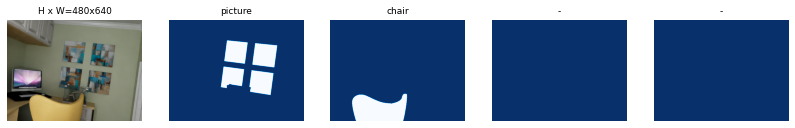

8335


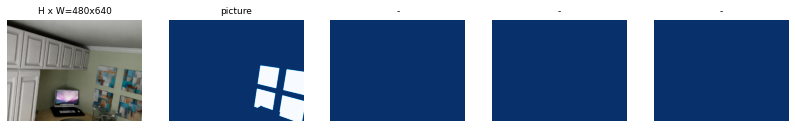

In [12]:
image_ids = dataset_train.load_view(2)
print(image_ids)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    print(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [8]:
class TrainConfig(interior_seq.InteriorNetConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 10
    NUM_CLASSES = len(selected_classes)  # background + num classes
    vmin = -1.
    vmax = 1.
    grid_dist = 2
    nvox = 100
    nvox_z = 100
    vsize = float(vmax - vmin) / nvox
    vox_bs = 1
    im_bs = 1
    samples = 50
    min_z = 1000
    max_z = 1000
    NUM_VIEWS = 2
    RECURRENT = False
    USE_RPN_ROIS = True
    DETECTION_MIN_CONFIDENCE = 0.0
    GRID_REAS = 'ident'
    
config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
GRID_REAS                      ident
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                36
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE      

In [9]:
import json
with open(os.path.join(ROOT_DIR,'data/InteriorNet/data/HD1/train/instance_mapping.json')) as json_file:
    instance_map = json.load(json_file)
#print(instance_map)

FileNotFoundError: [Errno 2] No such file or directory: '/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD1/train/instance_mapping.json'

In [ ]:
instance = np.random.choice(list(instance_map.keys()),1)[0]

obj_inst = np.asarray(instance_map[instance])
print(obj_inst.shape)
views = np.random.choice(range(obj_inst.shape[0]),2)
print(views)
image_ids = obj_inst[views][:,1]
print(image_ids)
#print(dataset_train.image_from_source_map)
print(dataset_train.load_view(2))

In [ ]:
# obj_inst = np.array(instance_map['17'])
# image_ids = obj_inst[0:config.NUM_VIEWS][:,1]
# # image_ids = [obj_inst[0][1], obj_inst[20][1]]
# image_ids = np.random.choice(dataset_train.image_ids, config.NUM_VIEWS*1)
image_ids = np.array(dataset_train.load_view(2))
# image_ids = np.array([300, 301])

image_pairs = image_ids.reshape([-1,config.NUM_VIEWS])
print(image_ids)
im = []
Rcam = []
print([config.NUM_VIEWS] + list(config.IMAGE_SHAPE))
# for image_id in image_ids:
#     image_id = dataset_train.image_from_source_map["interior.33FO4JXILITSO_id"+image_id]
#     image = dataset_train.load_image(image_id)
#     image, _, _, _, _ = utils.resize_image(image, min_dim=config.IMAGE_MIN_DIM, max_dim=config.IMAGE_MAX_DIM, mode="square")
#     im.append(image)
#     Rcam.append(dataset_train.load_R(image_id))
for image_pair in image_pairs:
    im = []
    Rcam = []
    Kmat = dataset_train.K
    for image_id in image_pair:
        image = dataset_train.load_image(image_id)
        image, _, _, _, _ = utils.resize_image(image, min_dim=config.IMAGE_MIN_DIM, max_dim=config.IMAGE_MAX_DIM, mode="square")
        im.append(image)
        Rcam.append(dataset_train.load_R(image_id))
    im = np.stack(im)
    Rcam = np.stack([Rcam])
    Kmat = np.stack([Kmat])
    print(im.shape)
    print(Rcam.shape)
    print(Kmat.shape)


# Free Memory
del image

from keras.backend.tensorflow_backend import set_session
config_tf = tf.ConfigProto()
config_tf.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config_tf.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config_tf)
set_session(sess)  # set this TensorFlow session as the default session for Keras
model = projection1.ProjectionNet(config)
im_res, grid = model.run([[im], Rcam, Kmat])
tf.reset_default_graph()
del model
del sess

In [ ]:
plt.imshow(im[1])
print(im[0].shape)
# cv2.imwrite(os.path.join(ROOT_DIR,'data/InteriorNet/Results/unproj/original.png'), im[1][:,:,::-1])

In [ ]:
plt.imshow(im[0])

In [ ]:
# print(grid.shape)
# unproj = grid[0,0,20,:,:,:]
# plt.imshow(unproj/255)
# cv2.imwrite(os.path.join(ROOT_DIR,'data/InteriorNet/Results/unproj/unproj.png'), unproj[:,:,::-1])

In [ ]:
print(im_res.shape)
im_resized, _, _, _, _ = utils.resize_image(im_res[0,38,:,:,:]/255, min_dim=config.IMAGE_MIN_DIM, max_dim=config.IMAGE_MAX_DIM, mode="square")
plt.imshow(im_resized)

In [ ]:
# cv2.imwrite(os.path.join(ROOT_DIR,'data/InteriorNet/Results/unproj/proj.png'), im_res[0,0,:,:,::-1])

In [ ]:
plt.imshow(grid[0,50,:,:,:]/255)